In [2]:
using TestImages, Images, QuartzImageIO, ImageView

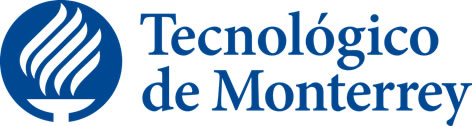

In [3]:
img = load("tec-logo.jpg")

The following isothermal first-order irreversible chemical reaction takes place in a parallel set of continuous stirred tank  reactors (CSTR):
$$ A \rightarrow B +C$$ 
Component $C$ is strongly volatile, such that we can safely assume that only components $A$ and $B$ leave any reactor
in liquid phase. Afterwards, the main product B is separated from the unreacted raw material A in a set of high-purity distillation columns. Finally, compounds A and B from the reaction-separation train are collected in two separated mixers. We would like to compute the  flowrate of the main feedstream   ($F_o$), as well as the optimal split ($F^1_o,F^2_o,F^3_o$)
of such stream,  such that process profit is maximized subject to meet product demands and holding raw material availability.




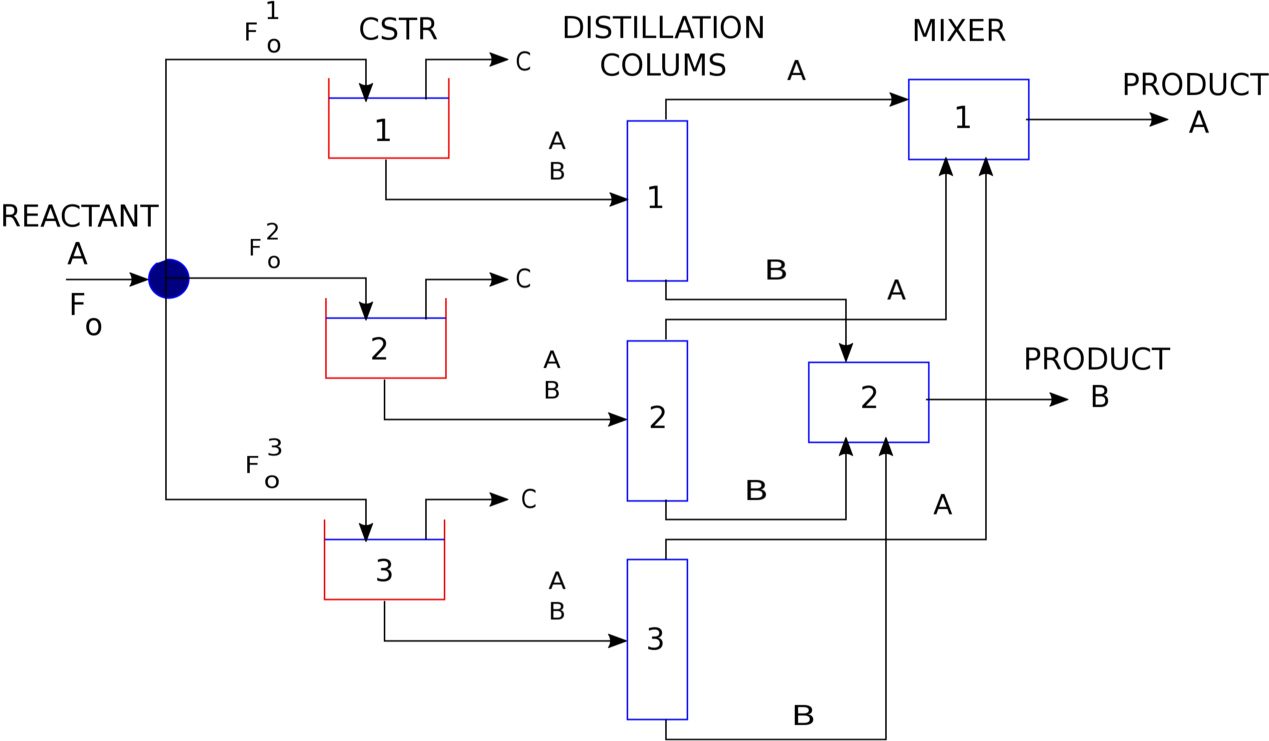

In [4]:
img = load("fig1_small_plant.png")

The maximum available amount of  reactant A is   60000 [Kg/h], whereas the demand of the main product B is 
30000 [kg/h]. Moreover, the molecular weights of components A, B and C are 27, 20 and 7 [kg/kgmol], respectively. The cost of reactant A is 10 [Dll/Kg] and the selling price of   product B is 20 [Dll/Kg], respectively.
You should also notice that there are bounds on the maximum amount of raw material that each CSTR can
manufacture. 
   
| CSTR  | K [1/h]  | Residence time $\theta$) [h]   | Maximum Load [Kg]|
|:-----:|:--------:|:------------------------------:|:----------------:|
|1      | 1        |         3                      | 21600            |
|2      | 0.8      | 4.5                            | 27000            |
|3      | 0.5      | 5                              | 16200            |


| Column | $\alpha$ | $\beta$ |
|:------:|:--------:|:-------:|
|1       | 0.97     |  0.03   |
|2       | 0.98     |  0.02   |
|3       | 0.96     |  0.01   |

For a given  isothermal first-order chemical reactor $i$  the output molar flowrate is given as follows (the superscript $f$ stands for feed stream):
$$ F_A,i = \frac{F^f_A,i}{1+K_i\theta_i} $$

You should note that for a given column $i$ the recovery factors are defined as follows (both recovery factors are defined for the distillate stream):
$$ \alpha_i = \frac{F_A,i}{F^f_A,i}, \quad \beta_i = \frac{F_B,i}{F^f_B,i}$$




In [1]:
using JuMP, Clp, Printf, Plots

In [2]:
small_plant = Model(solver=ClpSolver());

In [3]:
mwa    = 27  # [kg/kgmol]
mwb    = 20

k1     = 1    # [1/h]
k2     = 0.8
k3     = 0.5
theta1 = 3 # [h]
theta2 = 4.5 
theta3 = 5

alpha1 = 0.97
beta1  = 0.03
alpha2 = 0.98
beta2  = 0.02
alpha3 = 0.96
beta3  = 0.01 

profit_b = 20 # [$/h]
cost_a   = 10  # [$/h]
demand_b = 30000 # [kg/h] 
fmax_a   = 60000 # Max amount available of reactant A [kg/h]

fmax_r1  = 21600/mwa # Max capacity of reactor 1 [Kmol/h]
fmax_r2  = 27000/mwa # Max capacity of reactor 2 [Kmol/h]
fmax_r3  = 16200/mwa # Max capacity of reactor 3 [Kmol/h]
fbound   = 2000;

In [4]:
@variable(small_plant, fao1  >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, fao2  >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, fao3  >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, ffeed >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, f     >= 0, start = fbound)  # [kg/h]

@variable(small_plant, fa1   >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, fa2   >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, fa3   >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, fb1   >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, fb2   >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, fb3   >= 0, start = fbound)  # [kmol/h]

@variable(small_plant, fadc1_top >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, fbdc1_top >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, fadc1_bot >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, fbdc1_bot >= 0, start = fbound)  # [kmol/h]

@variable(small_plant, fadc2_top >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, fbdc2_top >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, fadc2_bot >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, fbdc2_bot >= 0, start = fbound)  # [kmol/h]

@variable(small_plant, fadc3_top >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, fbdc3_top >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, fadc3_bot >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, fbdc3_bot >= 0, start = fbound)  # [kmol/h]

@variable(small_plant, fa_top    >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, fb_top    >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, f_top     >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, fma       >= 0               )  # [kmol/h]

@variable(small_plant, fa_bot    >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, fb_bot    >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, f_bot     >= 0, start = fbound)  # [kmol/h]
@variable(small_plant, fmb       >= 0               )  # [kmol/h];

#### Molar flowrates from CSTRs

In [5]:
@constraint(small_plant, c1, fa1 == fao1/(1+k1*theta1) )
@constraint(small_plant, c2, fa2 == fao2/(1+k2*theta2) )
@constraint(small_plant, c3, fa3 == fao3/(1+k3*theta3) )
@constraint(small_plant, c4, fb1 == fao1-fa1 )
@constraint(small_plant, c5, fb2 == fao2-fa2 )
@constraint(small_plant, c6, fb3 == fao3-fa3 );

#### Molar flowrates from Distillation Columns

In [6]:
@constraint(small_plant, c7,   fadc1_top  == alpha1*fa1    )
@constraint(small_plant, c8,   fbdc1_top  == beta1*fb1     )
@constraint(small_plant, c9,   fadc1_bot  == fa1-fadc1_top )
@constraint(small_plant, c10,  fbdc1_bot  == fb1-fbdc1_top )

@constraint(small_plant, c11,  fadc2_top  == alpha2*fa2    )
@constraint(small_plant, c12,  fbdc2_top  == beta2*fb2     )
@constraint(small_plant, c13,  fadc2_bot  == fa2-fadc2_top )
@constraint(small_plant, c14,  fbdc2_bot  == fb2-fbdc2_top )

@constraint(small_plant, c15,  fadc3_top  == alpha3*fa3    )
@constraint(small_plant, c16,  fbdc3_top  == beta3*fb3     )
@constraint(small_plant, c17,  fadc3_bot  == fa3-fadc3_top )
@constraint(small_plant, c18,  fbdc3_bot  == fb3-fbdc3_top );

#### Mixers total flowrates

In [7]:
@constraint(small_plant, c19, fa_top == fadc1_top +  fadc2_top +  + fadc3_top )
@constraint(small_plant, c20, fb_top == fbdc1_top +  fbdc2_top +  + fbdc3_top )
@constraint(small_plant, c21, f_top  == fa_top + fb_top                       )
@constraint(small_plant, c22, fma    == mwa*f_top                             )

@constraint(small_plant, c23, fa_bot == fadc1_bot +  fadc2_bot +  + fadc3_bot )
@constraint(small_plant, c24, fb_bot == fbdc1_bot +  fbdc2_bot +  + fbdc3_bot )
@constraint(small_plant, c25, f_bot  == fa_bot + fb_bot                       )
@constraint(small_plant, c26, fmb    == mwb*f_bot                             );

#### Meet product demand

In [8]:
@constraint(small_plant, c27, fmb    >= demand_b );

#### Available amount of reactant A

In [9]:
@constraint(small_plant, c28, ffeed == fao1 + fao2 + fao3 );
@constraint(small_plant, c29, f     == mwa*ffeed );
@constraint(small_plant, c30, f     <= fmax_a );
@constraint(small_plant, c31, fao1  <= fmax_r1 );
@constraint(small_plant, c32, fao2  <= fmax_r2 );
@constraint(small_plant, c33, fao3  <= fmax_r3 );

In [10]:
@objective(small_plant, Max, profit_b*fmb - cost_a*f);

In [11]:
status_small_plant = solve(small_plant)

:Optimal

In [12]:
println("Objective function value = ", getobjectivevalue(small_plant))

@printf " fao1 : %f\n" getvalue(fao1)
@printf " fao2 : %f\n" getvalue(fao2)
@printf " fao3 : %f\n" getvalue(fao3)
@printf " ffeed: %f\n" getvalue(ffeed)
@printf " f    : %f\n" getvalue(f)



@printf " fa1: %f\n" getvalue(fa1)
@printf " fb1: %f\n" getvalue(fb1)
@printf " fa2: %f\n" getvalue(fa2)
@printf " fb2: %f\n" getvalue(fb2)
@printf " fa3: %f\n" getvalue(fa3)
@printf " fb3: %f\n" getvalue(fb3)

@printf " fadc1_top: %f\n" getvalue(fadc1_top)
@printf " fbdc1_top: %f\n" getvalue(fbdc1_top)
@printf " fadc1_bot: %f\n" getvalue(fadc1_bot)
@printf " fbdc1_bot: %f\n" getvalue(fbdc1_bot)

@printf " fadc2_top: %f\n" getvalue(fadc2_top)
@printf " fbdc2_top: %f\n" getvalue(fbdc2_top)
@printf " fadc2_bot: %f\n" getvalue(fadc2_bot)
@printf " fbdc2_bot: %f\n" getvalue(fbdc2_bot)

@printf " fadc3_top: %f\n" getvalue(fadc3_top)
@printf " fbdc3_top: %f\n" getvalue(fbdc3_top)
@printf " fadc3_bot: %f\n" getvalue(fadc3_bot)
@printf " fbdc3_bot: %f\n" getvalue(fbdc3_bot)

@printf " fa_top: %f\n" getvalue(fa_top)
@printf " fb_top: %f\n" getvalue(fb_top)
@printf " f_top : %f\n" getvalue(f_top)
@printf " fma   : %f\n" getvalue(fma)

@printf " fa_bot: %f\n" getvalue(fa_bot)
@printf " fb_bot: %f\n" getvalue(fb_bot)
@printf " f_bot : %f\n" getvalue(f_bot)
@printf " fmb   : %f\n" getvalue(fmb)
@printf " FTOTAL: %f\n" getvalue(fma)+getvalue(fmb)


Objective function value = 65080.469289164874
 fao1 : 800.000000
 fao2 : 1000.000000
 fao3 : 422.222222
 ffeed: 2222.222222
 f    : 60000.000000
 fa1: 200.000000
 fb1: 600.000000
 fa2: 217.391304
 fb2: 782.608696
 fa3: 120.634921
 fb3: 301.587302
 fadc1_top: 194.000000
 fbdc1_top: 18.000000
 fadc1_bot: 6.000000
 fbdc1_bot: 582.000000
 fadc2_top: 213.043478
 fbdc2_top: 15.652174
 fadc2_bot: 4.347826
 fbdc2_bot: 766.956522
 fadc3_top: 115.809524
 fbdc3_top: 3.015873
 fadc3_bot: 4.825397
 fbdc3_bot: 298.571429
 fa_top: 522.853002
 fb_top: 36.668047
 f_top : 559.521049
 fma   : 15107.068323
 fa_bot: 15.173223
 fb_bot: 1647.527950
 f_bot : 1662.701173
 fmb   : 33254.023464
 FTOTAL: 48361.091787
